# Publishing an openEO workflow as a User-Defined-Process (UDP) 

In this notebook, we want to show how to create an openEO User Defined Process(UDP). Here, we make use of an apply_dimension process that applies a process to all values along a dimension of a data cube.

The notebook involves a section on creating a concrete datacube, inspecting netCDF downloads, and developing a parameterized version stored as a UDP. 

In [ ]:
import json
import openeo
import xarray
import matplotlib.pyplot as plt
from utils import *

from openeo.processes import array_create, array_concat, ProcessBuilder
from openeo.api.process import Parameter

If you have a local JupyterLab instance running, you need to install the following libraries first: openeo, xarray, ipyleaflet, shapely and matplotlib:

`pip install openeo xarray shapely ipyleaflet matplotlib`

Make sure to restart the kernel and refresh the webpage.

In [ ]:
# Set some defaults for plots
plt.rcParams["figure.figsize"] = [5.0, 3.0]
plt.rcParams["figure.dpi"] = 75

Connect to the openEO Platform backend (at [openeo.cloud](https://openeo.cloud/)) and authenticate with OIDC.

In [ ]:
connection = openeo.connect("openeo.cloud").authenticate_oidc()

## Inspect raw data

Load initial data cube with raw `S1_GRD_SIGMA0_ASCENDING` data for a certain spatio-temporal extent.

In [ ]:
center = [46.49, 11.35]
zoom = 15

eoMap = openeoMap(center, zoom)
eoMap.map

In [ ]:
bbox = eoMap.getBbox()
print("west", bbox[0], "\neast", bbox[2], "\nsouth", bbox[1], "\nnorth", bbox[3])

In [ ]:
spatial_extent = {
    "west": bbox[0],
    "east": bbox[2],
    "south": bbox[1],
    "north": bbox[3],
    "crs": 4326,
}
temporal_extent = ["2023-05-01", "2023-07-01"]

In [ ]:
s1_raw = connection.load_collection(
    collection_id="SENTINEL1_GRD_SIGMA0",
    temporal_extent=temporal_extent,
    spatial_extent=spatial_extent,
    bands=["VH", "VV"],
)

Let's download this data cube synchronously as a netCDF file. 

This download command triggers the actual processing on the back-end: it sends the process graph to the back-end and waits for the result. It is a synchronous operation (the download() call blocks until the result is fully downloaded) and because we work on a small spatio-temporal extent, this should only take a couple of seconds.

In [ ]:
%%time
s1_raw.download("s1sar-raw.nc")

However, [batch job-based execution](https://open-eo.github.io/openeo-python-client/batch_jobs.html) is preferred when it is relatively larger spatial/temporal extent and the process may take some time to process.  

In [ ]:
ds = xarray.load_dataset("s1sar-raw.nc")
ds

We got these observations dates:

In [ ]:
ds.coords["t"].values

A quick plot for visual inspection.

In [ ]:
ds["VH"].isel(t=0).plot(vmin=0, vmax=0.5)

This section presented a straightforward example of retrieving and analyzing a `S1_GRD_SIGMA0_ASCENDING` data cube from the backend within a defined area of interest during a specified time frame.

## Collect statistics

As part of more detailed processing within the openEO platform, we'll gather temporal statistics using the `apply_dimension` process and a collection of statistical measures (minimum, maximum, quantiles, ...).

In [ ]:
def get_stats(data: ProcessBuilder) -> ProcessBuilder:
    """
    Collect stats for `data` (to be interpreted as an array of values along the "t" dimension).
    We should return a new array with the stats.
    """
    # Put some scalar stats (`min`, `max`, ... return a scalar value) in a new array
    scalar_stats = array_create(
        [
            data.min(),
            data.max(),
            data.mean(),
            data.sd(),
        ]
    )
    # The `quantiles` process returns an array on its own
    quantile_stats = data.quantiles([0.1, 0.5, 0.9])

    # Combine everything in a single array
    return array_concat(array1=scalar_stats, array2=quantile_stats)

In [ ]:
s1_stats = s1_raw.apply_dimension(
    process=get_stats,
    dimension="t",
    target_dimension="bands",
)
# Rename band labels, pairing original band names with stat names
s1_stats = s1_stats.rename_labels(
    "bands",
    [
        f"{b}_{s}"
        for b in s1_raw.metadata.band_names
        for s in ["min", "max", "mean", "sd", "q10", "q50", "q90"]
    ],
)

In [ ]:
# %%time
# s1_stats.download("s1grd-stats.nc")

# let's try batch job based execution in this process

job = s1_stats.execute_batch(
    title="Sentinel1_GRD_Statistics", outputfile="S1grd-stats.nc"
)


# # Alternatively if you want to seperately save process metadata
# s1_stats = s1_stats.save_result(format="netcdf")
# job = s1_stats.execute_batch(title="Sentinel 1 Statistics")

# # fetch your results

# results = job.get_results()
# results.download_files("output/batch_job")

In [ ]:
assets = job.get_results().get_assets()
assets[0].href

In [ ]:
ds = xarray.load_dataset("S1grd-stats.nc").drop_vars("crs")
ds

In [ ]:
ds[["VH_mean", "VV_mean"]].to_array().plot.imshow(col="variable", vmin=0, vmax=1)

## Build S1 SAR stats UDP

Suppose we want to save the above-described algorithm as a User-Defined-Process(UDP). Therefore, in this section, we define the input parameters, define the earlier workflow and then save it as a process. 

The only limitation of this approach, is that your workflow needs to be defined as a single process graph. So workflows that require multiple openEO invocations or complex parameter preprocessing won't work yet. However, thanks to the flexibility of openEO and the ability to include custom code as a UDF, a lot of algorithms can already be defined in a single openEO graph.

In [ ]:
import openeo
from openeo.api.process import Parameter
from openeo.processes import array_create, array_concat

Let us define the UDP parameters to allow specifying the spatio-temporal extent.

To make a service available to users, we might want to replace certain fixed values in your process graph with parameters that can be set by the user of your process. This provides you with a parameterised UDP.

In [ ]:
temporal_extent = Parameter(
    name="temporal_extent",
    description="The time window to calculate the stats for.",
    schema={"type": "array", "subtype": "temporal-interval"},
    default=["2023-05-01", "2023-07-30"],
)
spatial_extent = Parameter(
    name="spatial_extent",
    description="The spatial extent to calculate the stats for.",
    schema={"type": "object", "subtype": "bounding-box"},
    default={"west": 8.82, "south": 44.40, "east": 8.92, "north": 44.45},
)

In [ ]:
s1_raw = connection.load_collection(
    collection_id="S1_GRD_SIGMA0_ASCENDING",
    temporal_extent=temporal_extent,
    spatial_extent=spatial_extent,
    bands=["VH", "VV"],
)

# Unlike above, where we defined the `apply_dimension` process
# through a regular python function, we do it here compactily with a single "lambda".
s1_stats = s1_raw.apply_dimension(
    process=lambda data: array_concat(
        array1=array_create([data.min(), data.max(), data.mean(), data.sd()]),
        array2=data.quantiles([0.1, 0.5, 0.9]),
    ),
    dimension="t",
    target_dimension="bands",
)
# Rename band labels, pairing original band names with stat names
s1_stats = s1_stats.rename_labels(
    "bands",
    [
        f"{b}_{s}"
        for b in s1_stats.metadata.band_names
        for s in ["min", "max", "mean", "sd", "q10", "q50", "q90"]
    ],
)

Store this parameterized data cube as a UDP

In [ ]:
udp_sar = connection.save_user_defined_process(
    user_defined_process_id="s1_stats",
    process_graph=s1_stats,
    parameters=[temporal_extent, spatial_extent],
    summary="S1 SAR stats",
    description="Calculate S1 SAR stats (min, max, mean, sd, q10, q50, q90). This service can cost an approximate of 3-5 credits per sq km. This cost is based on resource consumpltion only and added-value cost has not been included.",
    public=True,
)

When saving a process, please note that saved processes are private by default, nonetheless can be used multiple times by an individual. Therefore, to share with a large audience, you will need a public URL that can be achieved once the process is saved as public.

In [ ]:
public_url, _ = [
    l["href"] for l in udp_sar.describe()["links"] if l["rel"] == "canonical"
]

## Use the saved UDP in the Python Client

Now, let’s evaluate our freshly created user-defined processes "s1_stats". We can use `datacube_from_process()` to create a DataCube from this process and only have to provide concrete temporal and spatial extents

Note: Since the `spatial_extent` and `temporal_extent` variable were re-assigned as a paramter definition, you might have lost their value, so please don't forget to re-define your interested extent in the cell below.

In [ ]:
sar = connection.datacube_from_process(
    "s1_stats",
    namespace=public_url,
    temporal_extent=["2023-05-01", "2023-07-30"],
    spatial_extent={"west": 8.82, "south": 44.40, "east": 8.92, "north": 44.45},
)

In [ ]:
sar.download("sar_udp.nc")

In [ ]:
ds = xarray.load_dataset("sar_udp.nc").drop_vars("crs")
ds

In [ ]:
ds[["VH_mean", "VV_mean"]].to_array().plot.imshow(col="variable", vmin=0, vmax=1)

Furthermore, you can directly can open the saved process directly by visiting the link:

https://editor.openeo.cloud/?wizard=UDP&wizard~process=s1_stats&discover=0

## Use the saved UDP in the openEO Platform Editor

Alternatively, we can also switch into the openEO Platform Editor to run the newly created UDP in a graphical web interface. Open **<https://editor.openeo.cloud?discover=0>** in your web browser.
It opens the editor, connects you to openEO Platform and asks you to login.
Once you've logged in, you can explore the offerings of openEO Platform and the data associcated with your user account, including batch jobs and UDPs ("Custom Processes" in the Editor).

The easiest way to run your UDP is to use the Wizard:
1. In the menu bar at the top you'll find the "Wizard". Click it to open.
2. You'll see a list of wizards, choose the "Run UDP" wizard.
3. It will show all your UDPs, choose the one you just created.
4. You'll now be asked to fill the parameters that you defined for your UDP.
5. After providing the parameters, you can click "Next" at the right bottom.
6. It will now open a list that allows to select the processing mode of your UDP:
   1. Batch Jobs
   2. Synchronous Processing
   3. Web Services
   4. Don't execute

   Select "Synchronous Processing" (for small tasks, recommended for this tutorial) or "Batch Jobs" (for larger tasks).
7. Click "Create" and the Editor will send your processing task to the backend. Once completed the result will be shown or downloaded.
   
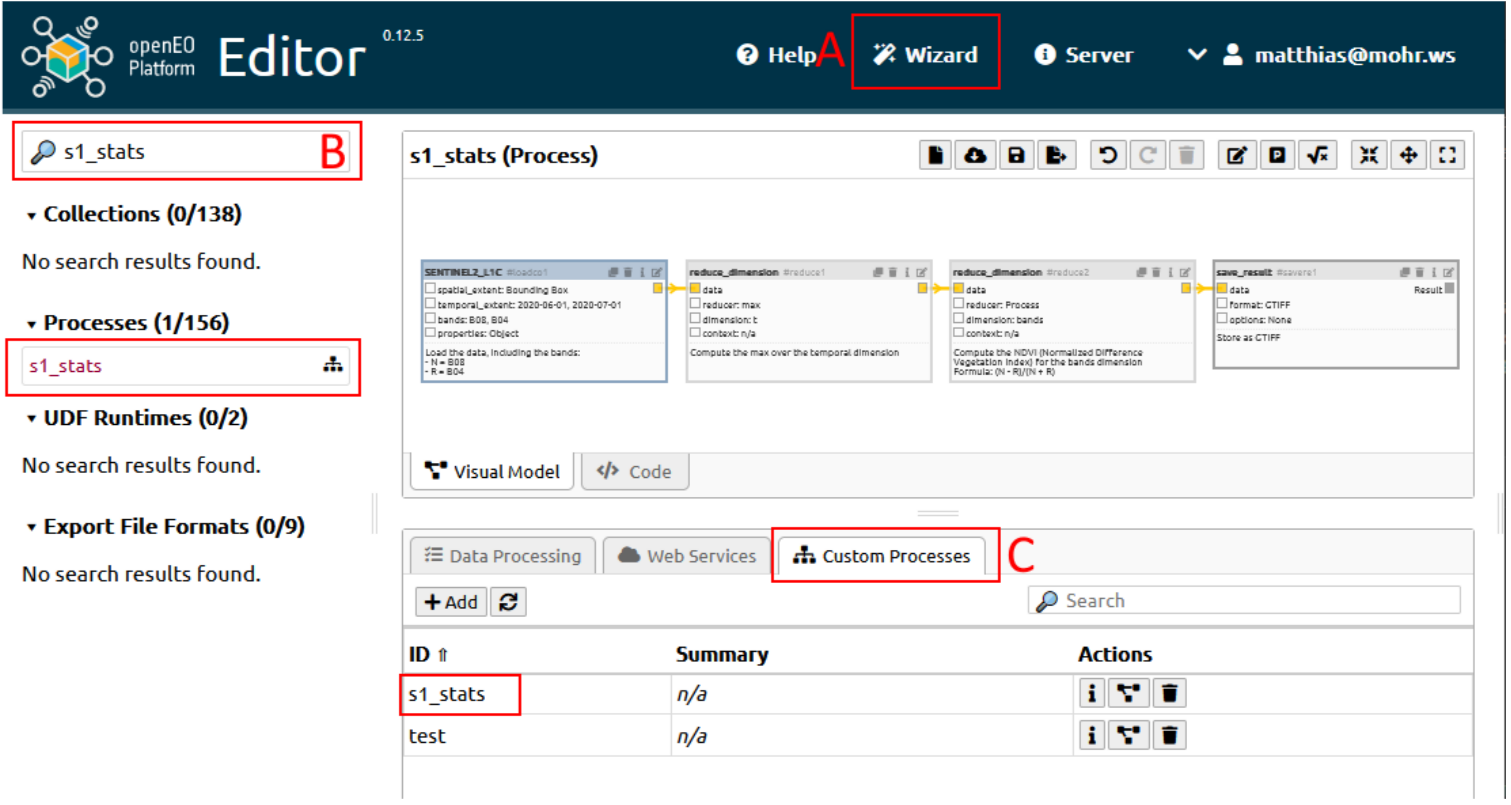

There are two other ways to interact with your UDP:
1. On the left side the UDP is listed in the "Processes" list. You can type your UDP name into the search area to find it. You could then drag and drop it in the Visual Model Builder and use it as part of other workflows.
2. In the lower part of the Editor, there's a tab with the title "Custom Processes". Here you can view, update and delete your UDPs.

## Publishing your service online

Once the UDP defined above is saved within the openEO platform, a user also has the option to add this service to the openEO Marketplace. 
To register a User Defined Process (UDP), you must have a public URL for your service. You'll also need to provide the saved process ID, which can be located within the public URL.

A detailed documentation on the process can be followed here:
[https://documentation.dataspace.copernicus.eu/Applications/PlazaDetails/ManageService.html#register-and-publish-your-service](https://documentation.dataspace.copernicus.eu/Applications/PlazaDetails/ManageService.html#register-and-publish-your-service)

# Credit Usage

Every openEO user is provided with a specific amount of credits. It's important to understand that examining data, processes, or creating process graphs like UDP doesn't cost any credits. However, executing these operations (synchronous or batch) which requires authentication does consume credits based on:

* CPU usage (measured in cores per second)
* Memory usage (measured in gigabytes per second)
* Storage usage (measured in gigabytes per day)
* Accessing data from specific layers (e.g., Sentinel Hub or commercial sources)
* Additional costs may apply if there's value-added content, typically provided by third-party services like 's1_stats.'
For this reason, when publishing such services online, it's advisable to include information about their credit consumption in the service description. 

You can estimate the credits your service might use by reviewing the job information in the web editor.

With refernce to the documentation available [here](https://docs.openeo.cloud/federation/accounting.html#platform-credit-rates), you can calculate the possible service usage per square kilometer. Suppose, in my case, for 1 square kilometer, it amounted to 2273 CPU seconds and 5,457,138 megabytes-seconds, equivalent to approximately 0.9 and 1.45 credits, respectively. Hence, the total credits consumed by this process come to approximately 2.35 credits.